<a href="https://colab.research.google.com/github/Ximena5745/Developer/blob/main/ModeloMLP_4240.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importación de librerias

In [1]:
pip install praat-parselmouth

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 31.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import os
import sys
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import parselmouth
from transformers import pipeline
from parselmouth.praat import call

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from IPython.display import Audio
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Importación de dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Cargar el dataset con las features extraídas de los audios
url = '/content/drive/MyDrive/Copia_full_data.csv'
emotion_df = pd.read_csv(url)

# Mostrar las primeras filas del dataset
emotion_df.head()
audio_features = emotion_df.copy()

In [ ]:
emotion_df.info()
emotion_df.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 21 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Registro                     4240 non-null   int64  
 1   Emocion                      4240 non-null   object 
 2   Path                         4240 non-null   object 
 3   Frecuencia de muestreo       4240 non-null   float64
 4   Duración (s)                 4240 non-null   float64
 5   Frecuencia Fundamental (Hz)  4240 non-null   float64
 6   Amplitud Máxima              4240 non-null   float64
 7   Amplitud Mínima              4240 non-null   float64
 8   Tasa de Cruce por Cero       4240 non-null   float64
 9   Chroma STFT                  4240 non-null   object 
 10  MFCC                         4240 non-null   object 
 11  Valor RMS                    4240 non-null   float64
 12  Entropía Espectral           4240 non-null   float64
 13  Formante F1 (Hz)  

,Registro,Emocion,Path,Frecuencia de muestreo,Duración (s),Frecuencia Fundamental (Hz),Amplitud Máxima,Amplitud Mínima,Tasa de Cruce por Cero,Chroma STFT,...,Valor RMS,Entropía Espectral,Formante F1 (Hz),Formante F2 (Hz),HNR (Harmonicity),Mel espectogramas,Frecuencia Centroidal,Rolloff,Bandwidth,Flatness
4235,11678,sad,/content/drive/MyDrive/EmotionsOnAudio_Data/Ne...,24414.0,2.363808,201.048297,0.212097,0.0,0.141355,[0.39851436 0.24732815 0.2350151 0.25599384 0...,...,0.034817,505.181274,482.915517,2878.284528,16.391260,[2.88684130e-01 2.89530128e-01 1.95786491e-01 ...,2851.372483,4879.445269,2435.420751,0.027372
4236,11679,sad,/content/drive/MyDrive/EmotionsOnAudio_Data/Ne...,24414.0,2.205128,203.999040,0.215210,0.0,0.110186,[0.29657784 0.27624103 0.20191664 0.205571 0...,...,0.029976,383.521973,469.653115,2839.769407,18.126351,[3.1746067e-02 9.1368712e-02 5.8057088e-02 2.2...,2372.694231,4059.065918,2327.063426,0.020903
4237,11680,sad,/content/drive/MyDrive/EmotionsOnAudio_Data/Ne...,24414.0,2.142623,210.033977,0.241119,0.0,0.112689,[0.27355883 0.341908 0.18740079 0.15470836 0...,...,0.048023,748.610596,451.441419,2751.461978,19.635043,[7.2217770e-02 6.5526538e-02 4.7490980e-02 2.3...,2361.604544,4059.586734,2219.075284,0.017930
4238,11681,sad,/content/drive/MyDrive/EmotionsOnAudio_Data/Ne...,24414.0,2.339273,207.905944,0.513397,0.0,0.105547,[0.30588835 0.3993841 0.29274982 0.23527357 0...,...,0.034240,483.406342,455.130785,2580.371736,19.776305,[1.23123074e+00 2.50449967e+00 9.03532124e+00 ...,2317.519456,3960.186323,2294.409084,0.013592
4239,11682,sad,/content/drive/MyDrive/EmotionsOnAudio_Data/Ne...,24414.0,2.171541,216.750383,0.197205,0.0,0.104657,[0.25996578 0.37817636 0.34056297 0.19174154 0...,...,0.033431,446.061615,533.279962,2641.199472,18.383111,[4.70786840e-02 2.48978660e-02 1.81458779e-02 ...,2442.531216,4449.933838,2363.154725,0.017884


In [ ]:
audio_features.columns


Index(['Registro', 'Emocion', 'Path', 'Frecuencia de muestreo', 'Duración (s)',
       'Frecuencia Fundamental (Hz)', 'Amplitud Máxima', 'Amplitud Mínima',
       'Tasa de Cruce por Cero', 'Chroma STFT', 'MFCC', 'Valor RMS',
       'Entropía Espectral', 'Formante F1 (Hz)', 'Formante F2 (Hz)',
       'HNR (Harmonicity)', 'Mel espectogramas', 'Frecuencia Centroidal',
       'Rolloff', 'Bandwidth', 'Flatness'],
      dtype='object')

# Exploración de datos

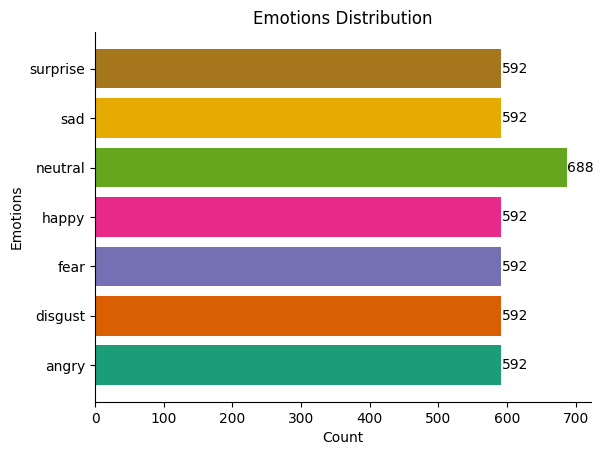

In [ ]:
# Agrupar datos por 'Emocion' y obtener el conteo
emotion_counts = emotion_df.groupby('Emocion').size()

# Definir una paleta de colores
colors = sns.color_palette('Dark2', len(emotion_counts))

# Crear un gráfico de barras horizontal
plt.barh(emotion_counts.index, emotion_counts.values, color=colors)

# Añadir etiquetas a cada barra
for index, value in enumerate(emotion_counts.values):
    plt.text(value, index, str(value), va='center')

# Quitar las líneas de los ejes superior y derecho
plt.gca().spines[['top', 'right']].set_visible(False)

# Etiquetas y título del gráfico
plt.xlabel('Count')
plt.ylabel('Emotions')
plt.title('Emotions Distribution')

# Mostrar el gráfico
plt.show()

In [ ]:
def clean_list_column(column):
    # Reemplazar los espacios por comas en las listas mal formateadas
    cleaned_column = column.apply(lambda x: np.array([float(i) for i in str(x).replace(' ', ',').replace('[', '').replace(']', '').split(',') if i]))
    return cleaned_column

# Aplicar la función a las columnas 'Chroma STFT' y 'MFCC'

emotion_df['Mel espectogramas'] = clean_list_column(emotion_df['Mel espectogramas'])

# Verificar que las columnas ahora son arrays numéricos
print(emotion_df['Chroma STFT'].head())
print(emotion_df['MFCC'].head())
print(emotion_df['Mel espectogramas'].head())

0    [0.51987237 0.5104598  0.5308735  0.55336916 0...
1    [0.661944   0.65347666 0.6185918  0.6136443  0...
2    [0.5063076  0.57467216 0.5571718  0.5211013  0...
3    [0.590252   0.58667654 0.5863295  0.60280424 0...
4    [0.6290957  0.60272986 0.58971983 0.5667398  0...
Name: Chroma STFT, dtype: object
0    [-5.6813879e+02  7.0809174e+01 -8.7602224e+00 ...
1    [-726.2172      68.54142      3.2933977   12.2...
2    [-5.5741827e+02  5.9952057e+01 -3.6888146e+00 ...
3    [-7.3248541e+02  8.0965508e+01  3.4866977e+00 ...
4    [-710.9753      67.56488      5.7822413   13.2...
Name: MFCC, dtype: object
0    [2.8313254e-05, 0.000240722962, 0.00310244807,...
1    [1.7018416e-05, 0.0014323465, 0.016623283, 0.0...
2    [7.24547644e-05, 0.000427532446, 0.0156923831,...
3    [1.44241485e-05, 0.000940073864, 0.0162270851,...
4    [2.11817514e-05, 0.0022920561, 0.0258112662, 0...
Name: Mel espectogramas, dtype: object


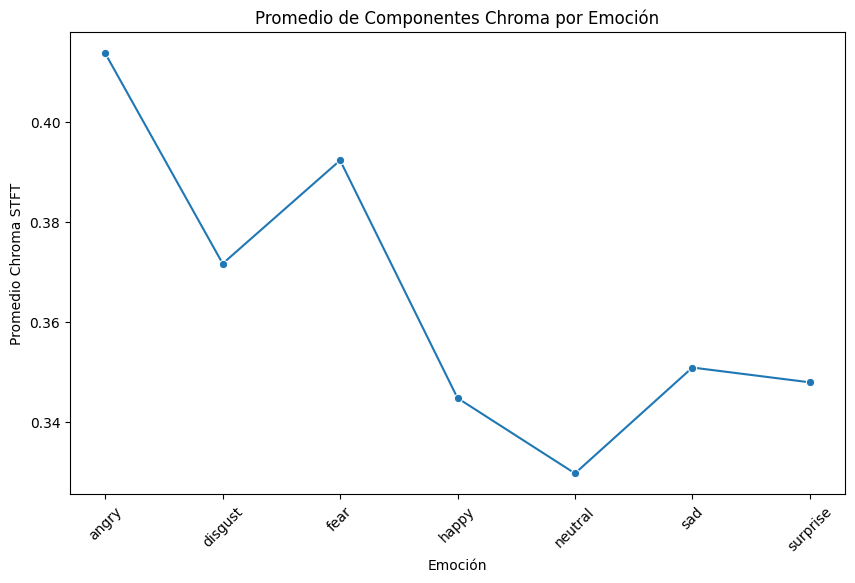

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Asegurarnos de que las listas de strings se conviertan a arrays numéricos
emotion_df['Chroma STFT'] = emotion_df['Chroma STFT'].apply(lambda x: np.fromstring(x.strip("[]"), sep=',') if isinstance(x, str) else x)

# Calcular el promedio de Chroma STFT por emoción
chroma_avg = emotion_df.copy()
chroma_avg['Chroma STFT'] = chroma_avg['Chroma STFT'].apply(lambda x: np.mean(x) if isinstance(x, np.ndarray) else x)

# Agrupar por emoción para obtener el promedio de Chroma STFT
chroma_avg = chroma_avg.groupby('Emocion')['Chroma STFT'].mean().reset_index()

# Renombrar la columna para reflejar el promedio
chroma_avg.rename(columns={'Chroma STFT': 'Promedio Chroma STFT'}, inplace=True)

# Unir el promedio al DataFrame original
emotion_df['Promedio Chroma STFT'] = emotion_df['Emocion'].map(chroma_avg.set_index('Emocion')['Promedio Chroma STFT'])

# Crear el gráfico de líneas
plt.figure(figsize=(10, 6))
sns.lineplot(data=chroma_avg, x='Emocion', y='Promedio Chroma STFT', marker='o')
plt.title('Promedio de Componentes Chroma por Emoción')
plt.xlabel('Emoción')
plt.ylabel('Promedio Chroma STFT')
plt.xticks(rotation=45)
plt.show()



In [ ]:
chroma_avg.columns

Index(['Emocion', 'Promedio Chroma STFT'], dtype='object')

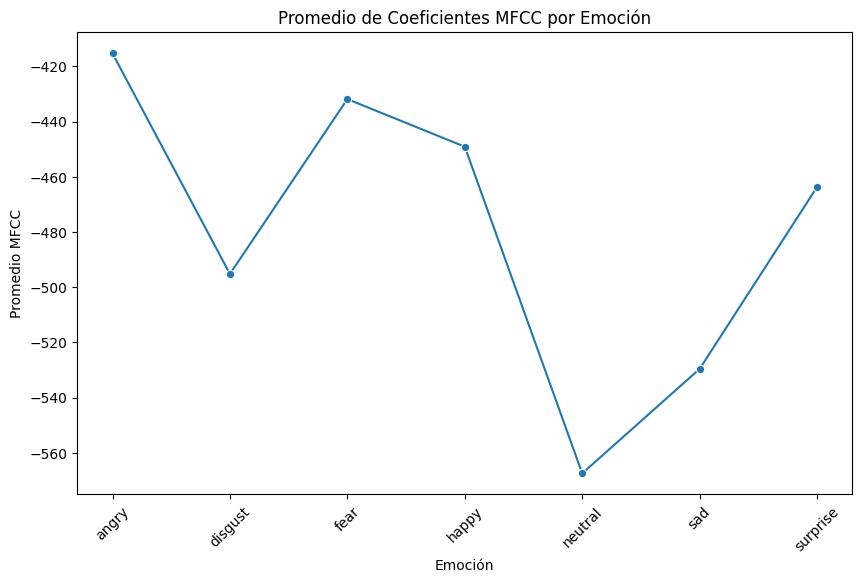

In [ ]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Asegurarte de que las listas de strings se conviertan a arrays numéricos
emotion_df['MFCC'] = emotion_df['MFCC'].apply(lambda x: np.fromstring(x.strip("[]"), sep=',') if isinstance(x, str) else x)

# Calcular el promedio de los coeficientes MFCC por emoción
mfcc_avg = emotion_df.copy()
mfcc_avg['MFCC'] = mfcc_avg['MFCC'].apply(lambda x: np.mean(x) if isinstance(x, np.ndarray) else x)

# Agrupar por emoción para obtener el promedio de MFCC
mfcc_avg = mfcc_avg.groupby('Emocion')['MFCC'].mean().reset_index()

# Renombrar la columna para reflejar el promedio
mfcc_avg.rename(columns={'MFCC': 'Promedio MFCC'}, inplace=True)

# Unir el promedio al DataFrame original
emotion_df['Promedio MFCC'] = emotion_df['Emocion'].map(mfcc_avg.set_index('Emocion')['Promedio MFCC'])

# Crear el gráfico de líneas
plt.figure(figsize=(10, 6))
sns.lineplot(data=mfcc_avg, x='Emocion', y='Promedio MFCC', marker='o')
plt.title('Promedio de Coeficientes MFCC por Emoción')
plt.xlabel('Emoción')
plt.ylabel('Promedio MFCC')
plt.xticks(rotation=45)
plt.show()



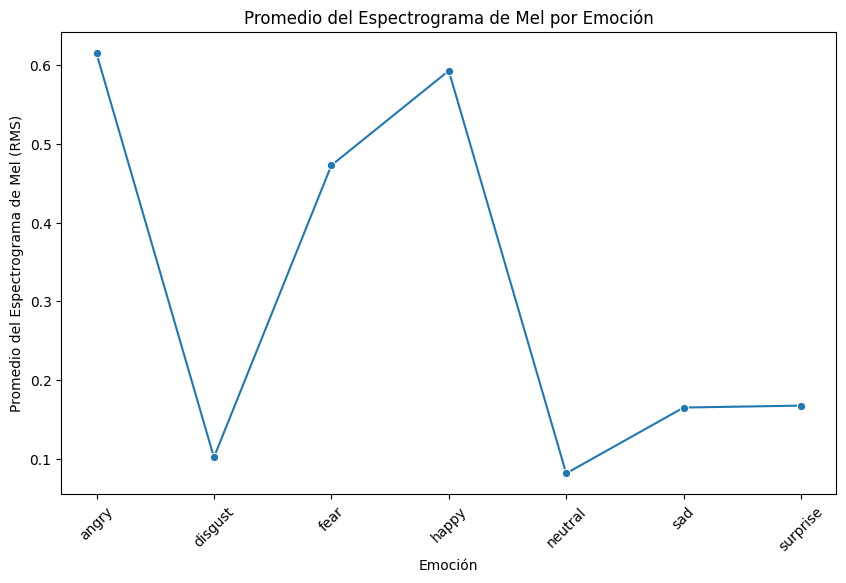

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Asegúrate de que las listas de strings se conviertan a arrays numéricos
emotion_df['Mel espectogramas'] = emotion_df['Mel espectogramas'].apply(lambda x: np.fromstring(x.strip("[]"), sep=',') if isinstance(x, str) else x)

# Calcular el promedio del espectrograma de Mel por emoción
mel_avg = emotion_df.copy()
mel_avg['Mel espectogramas'] = mel_avg['Mel espectogramas'].apply(lambda x: np.mean(x) if isinstance(x, np.ndarray) else x)

# Agrupar por emoción para obtener el promedio del espectrograma de Mel
mel_avg = mel_avg.groupby('Emocion')['Mel espectogramas'].mean().reset_index()

# Renombrar la columna para reflejar el promedio
mel_avg.rename(columns={'Mel espectogramas': 'Promedio Mel espectogramas'}, inplace=True)

# Unir el promedio al DataFrame original
emotion_df['Promedio Mel espectogramas'] = emotion_df['Emocion'].map(mel_avg.set_index('Emocion')['Promedio Mel espectogramas'])

# Crear el gráfico de líneas
plt.figure(figsize=(10, 6))
sns.lineplot(data=mel_avg, x='Emocion', y='Promedio Mel espectogramas', marker='o')
plt.title('Promedio del Espectrograma de Mel por Emoción')
plt.xlabel('Emoción')
plt.ylabel('Promedio del Espectrograma de Mel (RMS)')
plt.xticks(rotation=45)
plt.show()


In [ ]:
emotion_df.columns

Index(['Registro', 'Emocion', 'Path', 'Frecuencia de muestreo', 'Duración (s)',
       'Frecuencia Fundamental (Hz)', 'Amplitud Máxima', 'Amplitud Mínima',
       'Tasa de Cruce por Cero', 'Chroma STFT', 'MFCC', 'Valor RMS',
       'Entropía Espectral', 'Formante F1 (Hz)', 'Formante F2 (Hz)',
       'HNR (Harmonicity)', 'Mel espectogramas', 'Frecuencia Centroidal',
       'Rolloff', 'Bandwidth', 'Flatness', 'Promedio Chroma STFT',
       'Promedio MFCC', 'Promedio Mel espectogramas'],
      dtype='object')

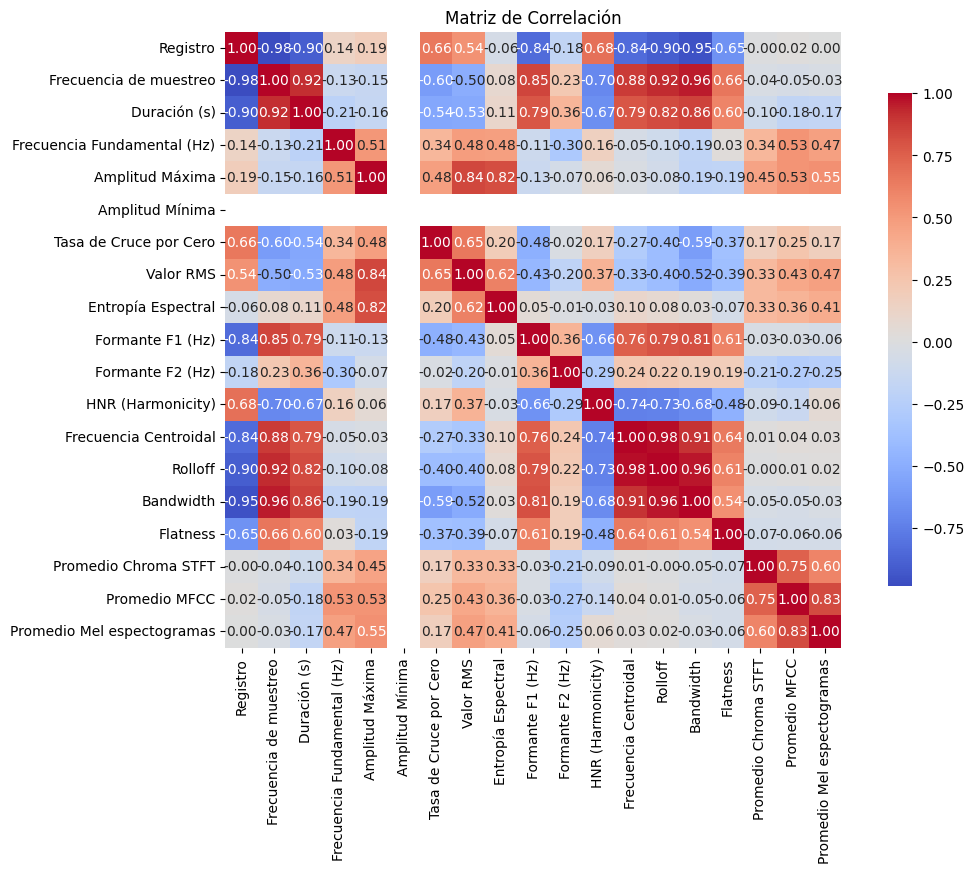

In [ ]:
# Filtrar solo las columnas numéricas
numerical_columns = emotion_df.select_dtypes(include=[np.number])

# Calcular la matriz de correlación
correlation_matrix = numerical_columns.corr()

# Crear un mapa de calor para la correlación
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Matriz de Correlación')
plt.show()


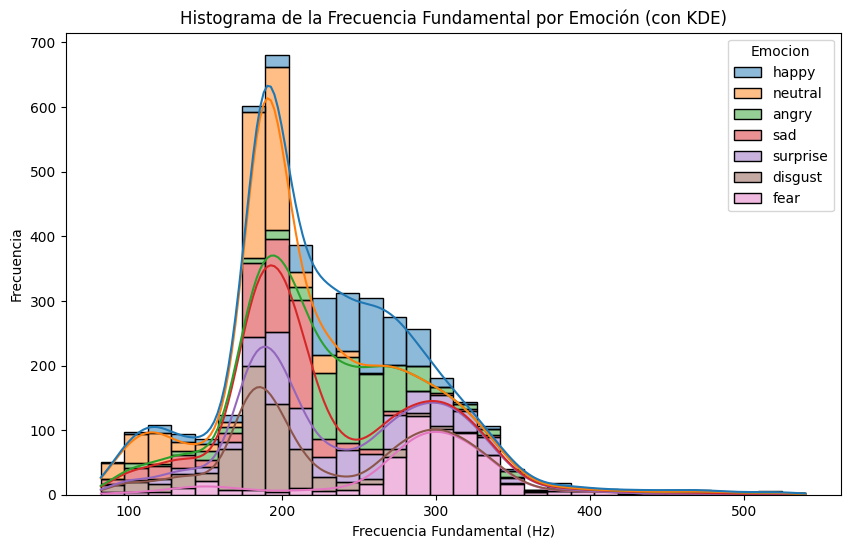

In [ ]:
# Histogramas con KDE
plt.figure(figsize=(10, 6))
sns.histplot(data=emotion_df, x='Frecuencia Fundamental (Hz)', hue='Emocion', multiple='stack', bins=30, kde=True)
plt.title('Histograma de la Frecuencia Fundamental por Emoción (con KDE)')
plt.xlabel('Frecuencia Fundamental (Hz)')
plt.ylabel('Frecuencia')
plt.show()


In [ ]:
# Dimensiones del DataFrame
print("Dimensiones del DataFrame:", emotion_df.shape)

# Información sobre los tipos de datos y valores nulos
print(emotion_df.info())

# Resumen estadístico de las características numéricas
print(emotion_df.describe())


Dimensiones del DataFrame: (4240, 24)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4240 entries, 0 to 4239
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Registro                     4240 non-null   int64  
 1   Emocion                      4240 non-null   object 
 2   Path                         4240 non-null   object 
 3   Frecuencia de muestreo       4240 non-null   float64
 4   Duración (s)                 4240 non-null   float64
 5   Frecuencia Fundamental (Hz)  4240 non-null   float64
 6   Amplitud Máxima              4240 non-null   float64
 7   Amplitud Mínima              4240 non-null   float64
 8   Tasa de Cruce por Cero       4240 non-null   float64
 9   Chroma STFT                  4240 non-null   object 
 10  MFCC                         4240 non-null   object 
 11  Valor RMS                    4240 non-null   float64
 12  Entropía Espectral           4240 non-

In [ ]:
# Mostrar las primeras filas del DataFrame para verificar la carga de datos
print(emotion_df.head())

   Registro  Emocion                                               Path  \
0         1    happy  /content/drive/MyDrive/EmotionsOnAudio_Data/Ne...   
1         2  neutral  /content/drive/MyDrive/EmotionsOnAudio_Data/Ne...   
2         3    angry  /content/drive/MyDrive/EmotionsOnAudio_Data/Ne...   
3         4      sad  /content/drive/MyDrive/EmotionsOnAudio_Data/Ne...   
4         5  neutral  /content/drive/MyDrive/EmotionsOnAudio_Data/Ne...   

   Frecuencia de muestreo  Duración (s)  Frecuencia Fundamental (Hz)  \
0                 48000.0      3.937271                   171.637228   
1                 48000.0      3.303292                   108.562358   
2                 48000.0      3.737062                   147.986714   
3                 48000.0      3.570229                   105.673211   
4                 48000.0      3.169833                   107.551108   

   Amplitud Máxima  Amplitud Mínima  Tasa de Cruce por Cero   Chroma STFT  \
0         0.139526              0.0    

# Modelado de datos

**PRUEBA CON RED NEURONAL MLP**

**Explicación de los parámetros:**

hidden_layer_sizes: Define la cantidad de neuronas en las capas ocultas. En este caso, estamos utilizando una capa oculta con 100 neuronas. Puedes ajustar este número o agregar más capas (por ejemplo, (100, 50) para dos capas con 100 y 50 neuronas, respectivamente).

activation: Usa la función de activación ReLU (Rectified Linear Unit), que es la más común en redes neuronales profundas.

solver: El optimizador adam es un método eficiente que combina las ventajas de los métodos de descenso de gradiente adaptativos.

learning_rate: Aquí usamos un aprendizaje adaptable que ajusta automáticamente la tasa de aprendizaje durante el entrenamiento.

max_iter: El número máximo de iteraciones (épocas) para entrenar el modelo. Puedes aumentar este número si no está convergiendo.

In [ ]:
emotion_df.columns

Index(['Registro', 'Emocion', 'Path', 'Frecuencia de muestreo', 'Duración (s)',
       'Frecuencia Fundamental (Hz)', 'Amplitud Máxima', 'Amplitud Mínima',
       'Tasa de Cruce por Cero', 'Chroma STFT', 'MFCC', 'Valor RMS',
       'Entropía Espectral', 'Formante F1 (Hz)', 'Formante F2 (Hz)',
       'HNR (Harmonicity)', 'Mel espectogramas', 'Frecuencia Centroidal',
       'Rolloff', 'Bandwidth', 'Flatness', 'Promedio Chroma STFT',
       'Promedio MFCC', 'Promedio Mel espectogramas'],
      dtype='object')

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.7547169811320755
Classification Report:
               precision    recall  f1-score   support

       angry       0.90      0.82      0.86       120
     disgust       0.71      0.72      0.71       117
        fear       0.83      0.74      0.78       110
       happy       0.75      0.66      0.70       104
     neutral       0.75      0.85      0.80       158
         sad       0.64      0.63      0.63       115
    surprise       0.73      0.81      0.77       124

    accuracy                           0.75       848
   macro avg       0.76      0.75      0.75       848
weighted avg       0.76      0.75      0.75       848



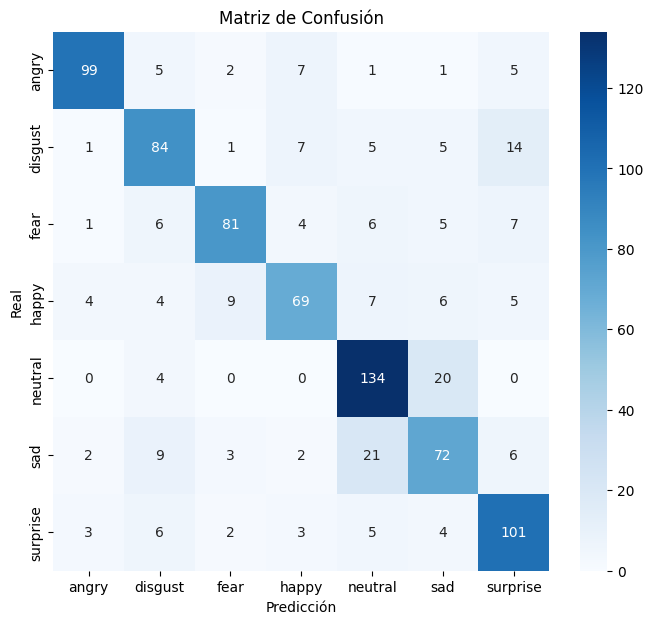

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report

# Prepare data
X = emotion_df[[ 'Frecuencia Fundamental (Hz)', 'Amplitud Máxima',
       'Tasa de Cruce por Cero',
        'Valor RMS',
       'Entropía Espectral', 'HNR (Harmonicity)', 'Frecuencia Centroidal', 'Rolloff', 'Bandwidth', 'Flatness',  'Formante F1 (Hz)', 'Formante F2 (Hz)']]
y = emotion_df['Emocion']

# Convert 'Chroma STFT' and 'MFCC' columns to numerical data
# This is where the fix is applied
def convert_to_numeric(value):
    try:
        return np.fromstring(value[1:-1], dtype=float, sep=' ')
    except:
        return np.nan  # Handle potential errors by replacing with NaN

# Convert all columns to numeric, forcing errors to NaN
X = X.apply(pd.to_numeric, errors='coerce')

# Fill NaN values with the mean of each column
X.fillna(X.mean(), inplace=True)

# Convert column names to strings
X.columns = X.columns.astype(str)

# Data Normalization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Data splitting
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define and train the MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(100, 50), activation='relu', solver='sgd',
                    learning_rate='constant', max_iter=500, random_state=42)
mlp.fit(X_train, y_train)

# Prediction and evaluation
y_pred = mlp.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()

# Optimización de hiperparámetros

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
45 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_p

Mejores hiperparámetros:  {'activation': 'relu', 'alpha': 0.026236641469099705, 'batch_size': 128, 'hidden_layer_sizes': (100, 50), 'learning_rate': 'adaptive', 'learning_rate_init': 0.005393365018657701, 'max_iter': 500, 'momentum': 0.8311148938298669, 'solver': 'sgd'}
Mejor score:  0.7821316140205369
Accuracy: 0.7759433962264151
Classification Report:
               precision    recall  f1-score   support

       angry       0.84      0.80      0.82       120
     disgust       0.86      0.75      0.80       117
        fear       0.71      0.76      0.74       110
       happy       0.68      0.70      0.69       104
     neutral       0.78      0.85      0.82       158
         sad       0.73      0.70      0.71       115
    surprise       0.81      0.82      0.82       124

    accuracy                           0.78       848
   macro avg       0.78      0.77      0.77       848
weighted avg       0.78      0.78      0.78       848



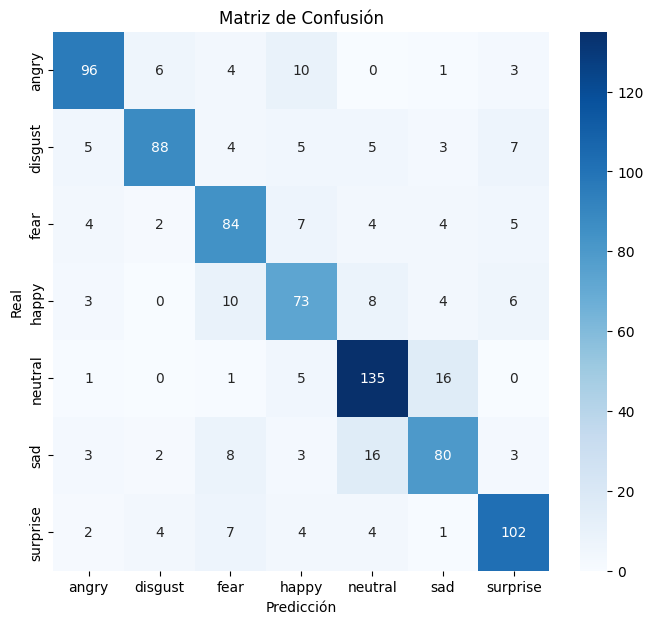

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Define el rango de hiperparámetros para la búsqueda
param_dist = {
    'hidden_layer_sizes': [(100,), (100, 50), (150, 100, 50)],  # Tamaños de las capas ocultas
    'activation': ['relu', 'tanh'],  # Funciones de activación
    'solver': ['sgd', 'adam'],  # Solvers posibles
    'alpha': uniform(0.0001, 0.05),  # Parámetro de regularización L2
    'learning_rate': ['constant', 'adaptive'],  # Tipos de tasa de aprendizaje
    'learning_rate_init': uniform(0.001, 0.01),  # Tasa de aprendizaje inicial
    'max_iter': [500, 1000],  # Número máximo de iteraciones
    'momentum': uniform(0.8, 0.99),  # Solo relevante si se usa 'sgd'
    'batch_size': [32, 64, 128]  # Tamaños de batch
}

# Inicializa el modelo base
mlp = MLPClassifier(random_state=42)

# Configura el RandomizedSearchCV
random_search = RandomizedSearchCV(mlp, param_distributions=param_dist, n_iter=20, cv=3, verbose=2, n_jobs=-1, random_state=42)

# Ejecuta la búsqueda
random_search.fit(X_train, y_train)

# Mejores hiperparámetros encontrados
print("Mejores hiperparámetros: ", random_search.best_params_)
print("Mejor score: ", random_search.best_score_)

# Evalúa el modelo con los mejores parámetros
y_pred = random_search.best_estimator_.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión')
plt.show()


**Optimización de Hiperparámetros**

Se ajustó hiperparámetros como el número de neuronas, la tasa de aprendizaje o el optimizador utilizando GridSearchCV o RandomizedSearchCV para mejorar el rendimiento del modelo.

**Pasos adicionales a considerar: **
Una vez que hayas entrenado el modelo con los mejores parámetros, podrías guardarlo para utilizarlo posteriormente sin tener que entrenarlo de nuevo.

**GUARDAR EL MODELO ENTRENADO Y OPTIMIZADO**

In [ ]:
# Este código guardará el modelo en un archivo llamado modelo_emociones.pkl que luego podrás cargar cuando lo necesites para hacer predicciones.

import joblib

# Guarda el modelo entrenado con los mejores hiperparámetros
joblib.dump(random_search.best_estimator_, 'modelo_emociones.pkl')

# Para cargar el modelo en el futuro y utilizarlo
modelo_cargado = joblib.load('modelo_emociones.pkl')

# Verifica que el modelo cargado funciona correctamente
y_pred_cargado = modelo_cargado.predict(X_test)
print("Accuracy con modelo cargado:", accuracy_score(y_test, y_pred_cargado))


Accuracy con modelo cargado: 0.7759433962264151


**PROBANDO EN MODELO CON AUDIOS**

In [ ]:
# Esto lo agregué para solucionar error: guardé el escalador
from sklearn.preprocessing import StandardScaler

# Inicializar el escalador y ajustarlo con los datos de entrenamiento originales
scaler = StandardScaler()
scaler.fit(X_train)

# Guardar el escalador
joblib.dump(scaler, 'scaler.pkl')



['scaler.pkl']

In [ ]:
# Cargo un audio y predigo la emoción

!pip install librosa --upgrade  # Actualiza librosa

import numpy as np
import librosa
import joblib
import librosa.feature  # Importa librosa.feature
from sklearn.preprocessing import StandardScaler  # Importa StandardScaler

# Función para extraer características del archivo de audio
def extraer_caracteristicas(audio_file):
    y, sr = librosa.load(audio_file, sr=None)

    # Extrae las mismas características que usaste durante el entrenamiento
    f0 = librosa.yin(y, fmin=50, fmax=300)  # Frecuencia fundamental
    rms = librosa.feature.rms(y=y).mean()  # Valor RMS
    zcr = librosa.feature.zero_crossing_rate(y).mean()  # Tasa de cruce por cero
    entropy = librosa.feature.spectral_flatness(y=y).mean()  # Entropía espectral
    hnr = librosa.effects.harmonic(y).mean()  # HNR
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr).mean()  # Centroidal
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr).mean()  # Rolloff
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr).mean()  # Ancho de banda espectral
    flatness = librosa.feature.spectral_flatness(y=y).mean()  # Flatness
    formant_f1 = librosa.lpc(y, order=2)[1]  # Formante F1
    formant_f2 = librosa.lpc(y, order=3)[2]  # Formante F2
    amplitud_max = np.max(y)  # Amplitud máxima


    # Asegúrate de que devuelva las mismas 12 características
    return np.array([f0.mean(), rms, zcr, entropy, hnr, centroid, rolloff, bandwidth, flatness, formant_f1, formant_f2, amplitud_max])


# Carga el modelo previamente guardado
modelo = joblib.load('modelo_emociones.pkl')

# Carga el escalador original utilizado durante el entrenamiento
scaler = joblib.load('scaler.pkl')  # Asegúrate de haber guardado el escalador durante el entrenamiento

# Procesa el archivo de audio
audio_file = '/content/drive/MyDrive/Dataset/neutral.wav'  # Audio de prueba (es neutral)
caracteristicas = extraer_caracteristicas(audio_file)

# Normaliza las características con el escalador original
caracteristicas_scaled = scaler.transform([caracteristicas])  # Usa .transform() y no .fit_transform()

# Predicción de la emoción
prediccion = modelo.predict(caracteristicas_scaled)

# Muestra el resultado
print("La emoción predicha es:", prediccion[0])


La emoción predicha es: neutral


In [ ]:
print("Características extraídas del audio:", caracteristicas)

Características extraídas del audio: [ 1.79016758e+02  3.01178228e-02  1.34830397e-01  1.87245160e-02
 -3.83319639e-05  2.78039353e+03  4.82808551e+03  2.42347595e+03
  1.87245160e-02 -1.46204197e+00  5.96130133e-01  1.52404785e-01]
